In [0]:
%tensorflow_version 1.x
!pip install adversarial-robustness-toolbox
!git clone https://github.com/tensorflow/cleverhans.git
!pip install cleverhans/

TensorFlow is already loaded. Please restart the runtime to change versions.
     |████████████████████████████████| 491kB 5.8MB/s 
     |████████████████████████████████| 7.1MB 13.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Cloning into 'cleverhans'...
remote: Enumerating objects: 13501, done.
remote: Total 13501 (delta 0), reused 0 (delta 0), pack-reused 13501
Receiving objects: 100% (13501/13501), 8.40 MiB | 10.27 MiB/s, done.
Resolving deltas: 100% (9494/9494), done.
Processing ./cleverhans
     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=253453 sha256=69d26fec91920c91e581bea99a17c9d535ea1418ad56f4205dbf36aff43d1cc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6roiso6a/wheels/d1/6b/1d/5cf7b3ca4c0cfc7f845628b8ed46366ab5f

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
from art.attacks import CarliniLInfMethod
from art.classifiers import KerasClassifier
from art.utils import load_dataset
import random

import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.disable_eager_execution()



# Step 1: Load the CIFAR 10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10")) # Original Dataset
print("x_train shape: " + str(x_train.shape) + "\n" + "x_train size: " + str(x_train.size) + "\n" +
      "y_train shape: " + str(y_train.shape) + "\n" + "y_train size: " + str(y_train.size) + "\n" +
      "x_test shape: " + str(x_test.shape) + "\n" + "x_test size: " + str(x_test.size) + "\n" +
      "y_test shape: " + str(y_test.shape) + "\n" + "y_test size: " + str(y_test.size) + "\n")



# Step 2: Load the victim model
classifier_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"  # @param {type:"string"}
IMAGE_SHAPE = (32, 32)
classifier = KerasClassifier(model=tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3,))]), clip_values=(min_, max_))



# Step 3: Evaluate the victim model on the benign dataset
predictions = classifier.predict(x_test)
accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
# print("Accuracy on benign test examples: {}%\n".format(accuracy_benign * 100))




x_train shape: (50000, 32, 32, 3)
x_train size: 153600000
y_train shape: (50000, 10)
y_train size: 500000
x_test shape: (10000, 32, 32, 3)
x_test size: 30720000
y_test shape: (10000, 10)
y_test size: 100000

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:

# Step 4 and 5
def getaccuracy_forone_extraction(x_test, y_test):
    # Step 4: Collect 10 instances of each case from test examples
    def exract_ten_classes( data, labels, classes=(0,1,2,3,4,5,6,7,8,9), no_instance=10 ):
        x_pre = [] # list to collect the x_test set
        y_pre = [] # list to collect the y_test set
        for class_label in range(0, 10): # loop through each of the classes
            index = random.randint(0, 5000) # randomly choose an index from the x_test, as means of getting different instances from each class
            iteration = no_instance # number of instance of each class to collect
            while (iteration != 0):
                if np.argmax(labels[index]) == classes[class_label]: # check if the current index label matches the specified class label we are looking for
                    x_pre.append(data[index]) # add the image to the x_test set
                    y_pre.append(int(class_label)) # add the image label to the y_test set
                    iteration = iteration - 1 # reduce # of instances by 1
                index = index + 1 # go to next index till next label is of the current class
        x = np.asarray(x_pre)  # append all 100, 10 of each class, images together
        y = keras.utils.to_categorical( np.asarray(y_pre), 10)  # append all 100, 10 of each class, labels together and do one hot encoding
        return x, y

    x_test_adv_pre, y_test_adv = exract_ten_classes( x_test, y_test ) # call method to get 10 instances of each class
    #print("x_test_adv_pre shape: " + str(x_test_adv_pre.shape) + "\n" + "x_test_adv_pre size: " + str(x_test_adv_pre.size) + "\n" +
          #"y_test_adv_pre shape: " + str(y_test_adv.shape) + "\n" + "y_test_adv_pre size: " + str(y_test_adv.size) + "\n")


    # Step 5: Generate adversarial test examples and Evaluate the ART classifier on adversarial test examples
    attack_eps_5 = CarliniLInfMethod(classifier=classifier, confidence=0.05, learning_rate=0.1) # generate attack with FGSM method with eps = 0.05
    x_test_adv_eps_5 = attack_eps_5.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_5 = classifier.predict(x_test_adv_eps_5) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_5 = np.sum(np.argmax(predictions_eps_5, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.05: {}%".format(accuracy_adv_eps_5 * 100))

    attack_eps_10 = CarliniLInfMethod(classifier=classifier, confidence=0.1, learning_rate=0.1) # generate attack with FGSM method with eps = 0.1
    x_test_adv_eps_10 = attack_eps_10.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_10 = classifier.predict(x_test_adv_eps_10) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_10 = np.sum(np.argmax(predictions_eps_10, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.1: {}%".format(accuracy_adv_eps_10 * 100))

    attack_eps_50 = CarliniLInfMethod(classifier=classifier, confidence=0.5, learning_rate=0.1) # generate attack with FGSM method with eps = 0.5
    x_test_adv_eps_50 = attack_eps_50.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_50 = classifier.predict(x_test_adv_eps_50) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_50 = np.sum(np.argmax(predictions_eps_50, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.5: {}%".format(accuracy_adv_eps_50 * 100))

    attack_eps_95 = CarliniLInfMethod(classifier=classifier, confidence=0.95, learning_rate=0.1) # generate attack with FGSM method with eps = 0.95
    x_test_adv_eps_95 = attack_eps_95.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_95 = classifier.predict(x_test_adv_eps_95) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_95 = np.sum(np.argmax(predictions_eps_95, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.95: {}%".format(accuracy_adv_eps_95 * 100))

    accuracies = [accuracy_adv_eps_5 * 100, accuracy_adv_eps_10 * 100, accuracy_adv_eps_50 * 100, accuracy_adv_eps_95 * 100] # create a list which holds the accuracy of the classifier with differnt values of epsilon for the FGSM attack

    all_count = [] # used to hold the accuracy of each attack on each label, i.e. original, eps = 5, eps 10, eps = 50, eps = 95
    for j in range(0, 100, 10): # iterate through each class
        count = [0, 0, 0, 0, 0] # used to hold accuracy of each attack for this instance of the label
        for i in range(j, j + 10): # loop through each instance of the current class
            sample_pre = x_test_adv_pre[i, :] # load the current image from the x set
            label_pre = np.argmax(classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2])))) # predict the label of the original image from x set
            sample_post_eps_5 = x_test_adv_eps_5[i, :]
            label_post_eps_5 = np.argmax(classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
            sample_post_eps_10 = x_test_adv_eps_10[i, :]
            label_post_eps_10 = np.argmax(classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
            sample_post_eps_50 = x_test_adv_eps_50[i, :]
            label_post_eps_50 = np.argmax(classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
            sample_post_eps_95 = x_test_adv_eps_95[i, :]
            label_post_eps_95 = np.argmax(classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
            if (label_pre == np.argmax(y_test_adv[i])): # if's are to update the count list to tally correct predictions
                count[0] = count[0] + 1
            if (label_post_eps_5 == np.argmax(y_test_adv[i])):
                count[1] = count[1] + 1
            if (label_post_eps_10 == np.argmax(y_test_adv[i])):
                count[2] = count[2] + 1
            if (label_post_eps_50 == np.argmax(y_test_adv[i])):
                count[3] = count[3] + 1
            if (label_post_eps_95 == np.argmax(y_test_adv[i])):
                count[4] = count[4] + 1
        all_count.append(count) # append the current class's predictions for each attack to the all_count list
    #print(all_count)

    return accuracies, x_test_adv_pre, x_test_adv_eps_5, x_test_adv_eps_10, x_test_adv_eps_50, x_test_adv_eps_95, y_test_adv, all_count




In [0]:

# Step 6: Get Statistical Results
accu = [] # used to hold the accuracy of each epsilon value per round
labeltally = [] # used to hold the total number of correct predictions per round per epsilon value
for i in range(0, 10): # do steps 5 and 6, 10 times for averaging purposes
    result = getaccuracy_forone_extraction(x_test, y_test) # call the function getaccuracy_forone_extraction
    accu.append(result[0]) # append the accuracy results of the current function call to the accu list
    labeltally.append(result[7]) # append the all_count results of the current function call to the labeltally list

final_accuracies = [] # used to hold the average accuracy of each epsilon value
for i in range(0, 4): # loop through each epsilon value
    x = (accu[0][i] + accu[1][i] + accu[2][i] + accu[3][i] + accu[4][i] + accu[5][i] + accu[6][i] + accu[7][i] + accu[8][i] + accu[9][i]) / 10 # find average or each attack across all rounds
    final_accuracies.append(x)

print()
print("Accuracy on benign test examples: {}%".format(accuracy_benign * 100))
print("Average Accuracy on adversarial test examples with confidence = 0.05: {}%".format(final_accuracies[0]))
print("Average Accuracy on adversarial test examples with confidence = 0.1: {}%".format(final_accuracies[1]))
print("Average Accuracy on adversarial test examples with confidence = 0.5: {}%".format(final_accuracies[2]))
print("Average Accuracy on adversarial test examples with confidence = 0.95: {}%".format(final_accuracies[3]))
print()

labelaccuracy = [] # used to hold the average value of the total number of correct predictions per epsilon value
for j in range(0, 10):
    x = []
    for i in range(0, 5):
        x.append(labeltally[0][j][i] + labeltally[1][j][i] + labeltally[2][j][i] + labeltally[3][j][i] + labeltally[4][j][i] + labeltally[5][j][i] + labeltally[6][j][i]
                 + labeltally[7][j][i] + labeltally[8][j][i] + labeltally[9][j][i])
    labelaccuracy.append(x)

Labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
for i in range(0, 10):
    print("Classifier with benign example has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][0]) + "%")
    print("Carlini L2 Method with confidence = 0.05 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][1]) + "%")
    print("Carlini L2 Method with confidence = 0.10 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][2]) + "%")
    print("Carlini L2 Method with confidence = 0.50 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][3]) + "%")
    print("Carlini L2 Method with confidence = 0.95 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][4]) + "%")
    print()

accuracies = result[0]
x_test_adv_pre = result[1]
x_test_adv_eps_5 = result[2]
x_test_adv_eps_10 = result[3]
x_test_adv_eps_50 = result[4]
x_test_adv_eps_95 = result[5]
y_test_adv = result[6]




Accuracy on benign test examples: 94.52000000000001%
Average Accuracy on adversarial test examples with confidence = 0.05: 3.1%
Average Accuracy on adversarial test examples with confidence = 0.1: 3.1%
Average Accuracy on adversarial test examples with confidence = 0.5: 3.1%
Average Accuracy on adversarial test examples with confidence = 0.95: 3.1%

Classifier with benign example has Airplane recognition average accuracy of = 95%
Carlini L2 Method with confidence = 0.05 has Airplane recognition average accuracy of = 3%
Carlini L2 Method with confidence = 0.10 has Airplane recognition average accuracy of = 3%
Carlini L2 Method with confidence = 0.50 has Airplane recognition average accuracy of = 3%
Carlini L2 Method with confidence = 0.95 has Airplane recognition average accuracy of = 3%

Classifier with benign example has Automobile recognition average accuracy of = 97%
Carlini L2 Method with confidence = 0.05 has Automobile recognition average accuracy of = 3%
Carlini L2 Method with 

In [0]:


# Step 7: Plot Results
for ind in range(0, 100, 5):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('Adversarial Attack On Victim Model', fontsize=24, fontweight='bold')
    columns = 5
    rows = 7
    ax = []

    ax.append(fig.add_subplot(rows, columns, 1))
    plt.text(0.38, 0.1, 'Original Image', fontsize=10, fontweight='bold')
    plt.axis('off')

    eps = [0.05, 0.1, 0.5, 0.95]
    for i in range(2, 6):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.1, 'Adversarial Image Conf = ' + str(eps[i - 2]), fontsize=10, fontweight='bold')
        plt.axis('off')

    imageindex = ind
    for i in range(5, columns*rows - 6, 5):
        sample_pre = x_test_adv_pre[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 1) )
        label_pre = np.argmax(classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_pre))
        plt.imshow(sample_pre)

        sample_post_eps_5 = x_test_adv_eps_5[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 2) )
        label_post_eps_5 = np.argmax(classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_5))
        plt.imshow(sample_post_eps_5)

        sample_post_eps_10 = x_test_adv_eps_10[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 3))
        label_post_eps_10 = np.argmax(classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_10))
        plt.imshow(sample_post_eps_10)

        sample_post_eps_50 = x_test_adv_eps_50[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 4))
        label_post_eps_50 = np.argmax(classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_50))
        plt.imshow(sample_post_eps_50)

        sample_post_eps_95 = x_test_adv_eps_95[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 5))
        label_post_eps_95 = np.argmax(classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_95))
        plt.imshow(sample_post_eps_95)

        imageindex = imageindex + 1


    ax.append(fig.add_subplot(rows, columns, 31))
    plt.text(0.0, 0.5, "Accuracy on benign test examples: {}%".format(round(accuracy_benign * 100),2), fontsize=8, fontweight='bold')
    plt.axis('off')

    for i in range(32, 36):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.5, "Accuracy on test examples confidence = " + str(eps[i-32]) + ": {}%".format(round(final_accuracies[i-32]), 2), fontsize=8, fontweight='bold')
        plt.axis('off')

    fig.tight_layout(h_pad=5.0, w_pad=5.0)
    plt.show()

In [0]:
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install adversarial-robustness-toolbox
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name
from art.defences import JpegCompression
from art.defences import TotalVarMin
from art.defences import GaussianNoise
from art.defences import PixelDefend
from art.defences import ClassLabels


  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-dr09o0x7
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-dr09o0x7
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp36-none-any.whl size=794841 sha256=d014bc4dbfe9680a50f2beb333bb1a27f0020adc4e34a65696b875256df24522
  Stored in directory: /tmp/pip-ephem-wheel-cache-8d4m0jsq/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


Defense: JPEG Compression 
Prediction of original sample: tiger shark, Galeocerdo cuvieri - confidence 6.12
Prediction of adversarial sample: tench, Tinca tinca - confidence 9.23


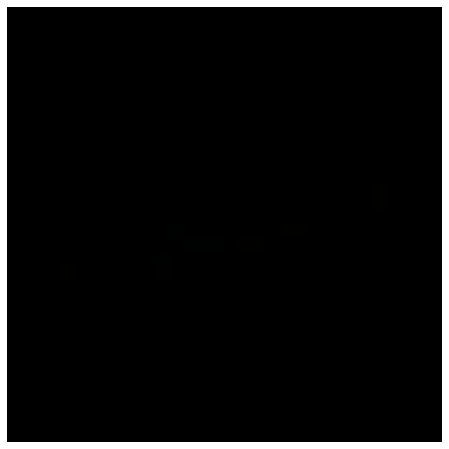

In [0]:
ss = JpegCompression(clip_values=(min_, max_))

x_art_def, _ = ss(x_test)
x_art_adv_def, _ = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: JPEG Compression ")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()


Defense: Gaussian Noise
Prediction of original sample: stingray - confidence 8.71
Prediction of adversarial sample: stingray - confidence 7.93


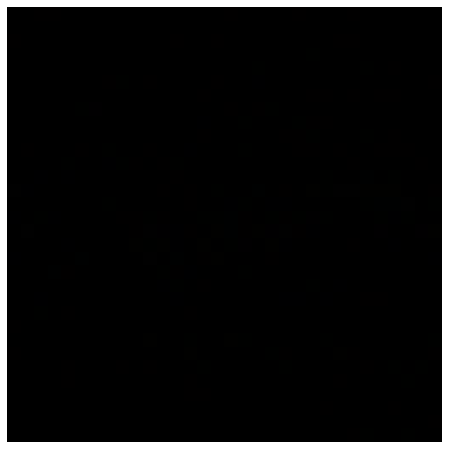

In [0]:
ss = GaussianNoise()

x_art_def = ss(x_test)
x_art_adv_def = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: Gaussian Noise")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()

Defense: Total Variance Minimization
Prediction of original sample: tiger shark, Galeocerdo cuvieri - confidence 6.52
Prediction of adversarial sample: hen - confidence 11.60


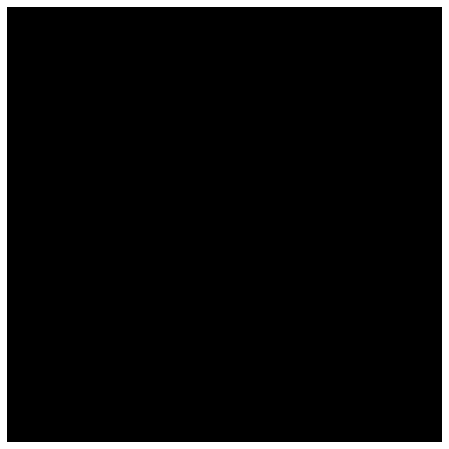

In [0]:
ss = TotalVarMin(clip_values=(min_, max_))
x_art_def, _ = ss(x_test)
x_art_adv_def, _ = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: Total Variance Minimization")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()


Defense: Class Labels Compression 
Prediction of original sample: tiger shark, Galeocerdo cuvieri - confidence 6.70
Prediction of adversarial sample: tiger shark, Galeocerdo cuvieri - confidence 6.70


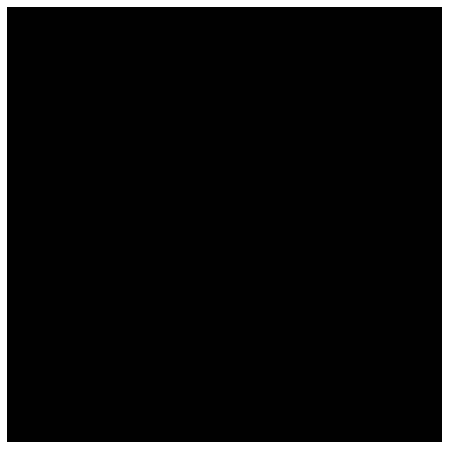

In [0]:
ss = ClassLabels()

x_art_def = ss(x_test)
x_art_adv_def = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: Class Labels Compression ")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()